## Import Library

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

## Overview

In [3]:
df = pd.read_csv('/kaggle/input/cluster-perkotaan-x-perdesaan/Jumlah Penduduk Miskin (Ribu Jiwa) Menurut Provinsi dan Daerah 2024.csv')
df

,Provinsi,Semester 1 (Maret) Perkotaan,Semester 2 (September) Perkotaan,Semester 1 (Maret) Perdesaan,Semester 2 (September) Perdesaan
0,ACEH,190.55,168.71,613.98,550.25
1,SUMATERA UTARA,697.46,623.78,530.55,487.14
2,SUMATERA BARAT,139.12,125.69,206.62,189.75
3,RIAU,200.91,183.28,291.34,289.76
4,JAMBI,118.39,120.63,147.03,152.08
5,SUMATERA SELATAN,342.34,310.04,641.90,638.81
6,BENGKULU,94.67,86.71,186.69,174.44
7,LAMPUNG,244.04,239.51,697.19,699.80
8,KEP. BANGKA BELITUNG,30.40,37.09,39.55,41.49
9,KEP. RIAU,112.28,102.23,26.03,22.72


## Exploratory Data Analysis

In [4]:
df.shape

(38, 5)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 5 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Provinsi                          38 non-null     object 
 1   Semester 1 (Maret) Perkotaan      38 non-null     float64
 2   Semester 2 (September) Perkotaan  38 non-null     float64
 3   Semester 1 (Maret) Perdesaan      37 non-null     float64
 4   Semester 2 (September) Perdesaan  37 non-null     float64
dtypes: float64(4), object(1)
memory usage: 1.6+ KB


In [6]:
df.isnull().sum()

Provinsi                            0
Semester 1 (Maret) Perkotaan        0
Semester 2 (September) Perkotaan    0
Semester 1 (Maret) Perdesaan        1
Semester 2 (September) Perdesaan    1
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Semester 1 (Maret) Perkotaan,38.0,306.247105,588.277380,5.97,31.22,103.475,237.9425,2921.52
Semester 2 (September) Perkotaan,38.0,290.699737,556.432689,7.14,33.16,98.525,236.7800,2780.46
Semester 1 (Maret) Perdesaan,37.0,367.076757,489.237510,24.65,102.39,186.690,352.5100,2339.99
Semester 2 (September) Perdesaan,37.0,351.571622,470.455501,16.05,95.88,174.440,321.4800,2304.70


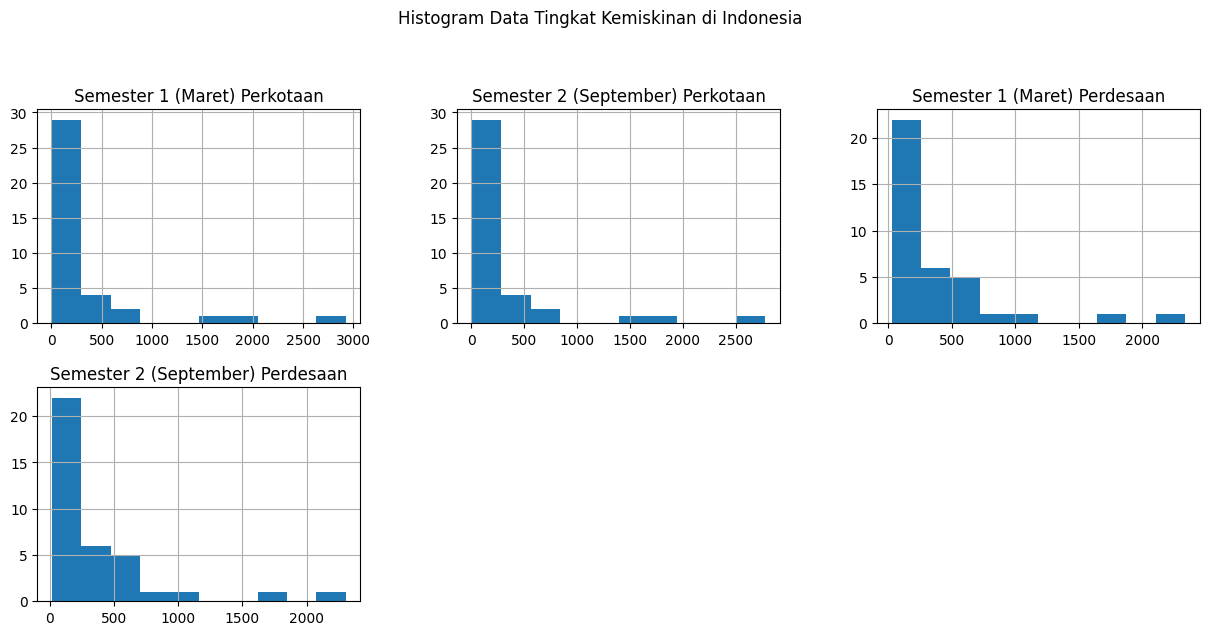

In [8]:
def plot_histograms(data):
    data.hist(bins=10, figsize=(15,10), layout=(3,3))
    plt.suptitle("Histogram Data Tingkat Kemiskinan di Indonesia")
    plt.show()

plot_histograms(df)

In [9]:
def count_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound)).sum()

outlier_counts = {}
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    outlier_counts[col] = count_outliers_iqr(df[col])

outliers_counts_df = pd.DataFrame(list(outlier_counts.items()), columns=['Column', 'Outliers Count'])

outliers_counts_df

,Column,Outliers Count
0,Semester 1 (Maret) Perkotaan,5
1,Semester 2 (September) Perkotaan,5
2,Semester 1 (Maret) Perdesaan,4
3,Semester 2 (September) Perdesaan,5


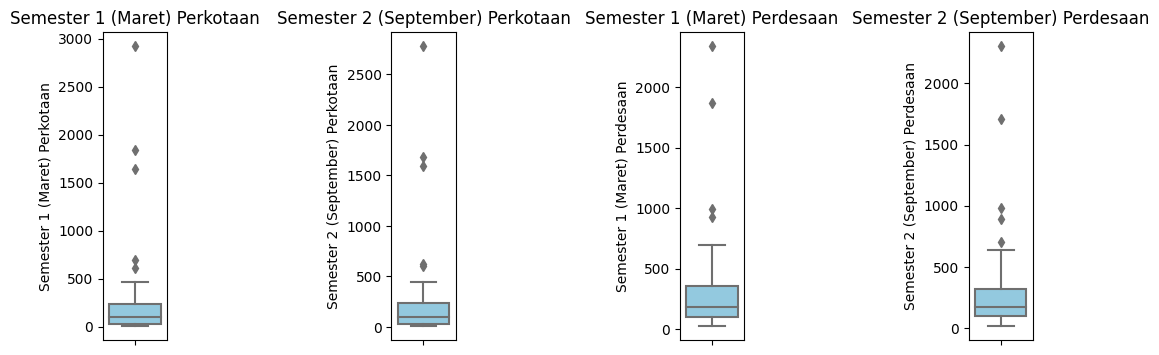

In [10]:
def box_plot(df):
  variables = df.select_dtypes(exclude = 'object').columns
  fig, axes = plt.subplots(1, 4, figsize = (12, 4)) 
  fig.subplots_adjust(hspace = 3.5, wspace = 3.5) 

  for i, var in enumerate(variables):
    sns.boxplot(y=var, data=df, color = "skyblue", ax=axes[i])
    axes[i].set_title(var)

  plt.show()

box_plot(df)

## Preprocessing

In [11]:
df = df.dropna()

In [12]:
encoder = LabelEncoder()

df[['Provinsi']] = df[['Provinsi']].apply(encoder.fit_transform)

In [13]:
scaler = MinMaxScaler()

x = scaler.fit_transform(df)

## Modelling

### K-Means

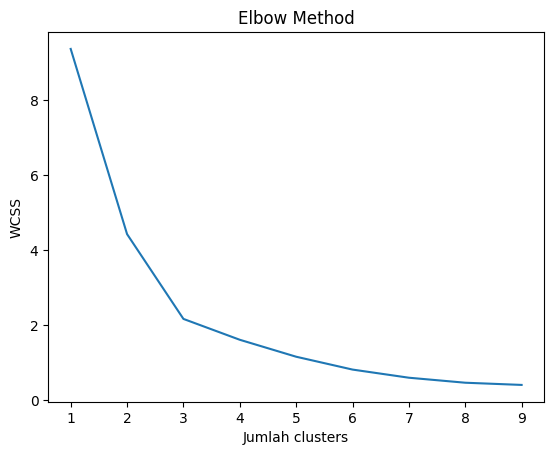

In [14]:
wcss = []
for i in range(1, 10):
  kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
  kmeans.fit(x)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 10), wcss)
plt.title('Elbow Method')
plt.xlabel('Jumlah clusters')
plt.ylabel('WCSS')
plt.show()

In [15]:
model = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_pred = model.fit_predict(x)

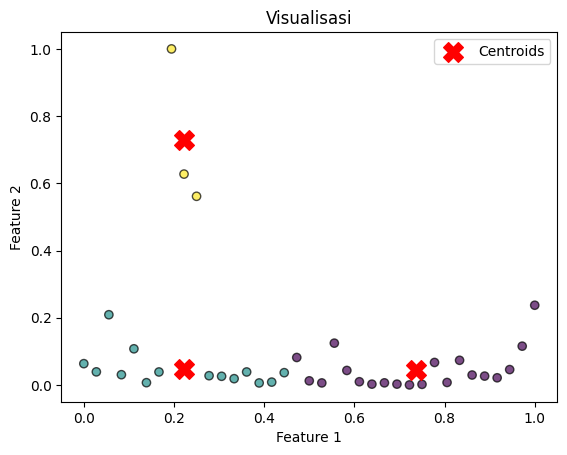

In [18]:
plt.scatter(x[:, 0], x[:, 1], c=y_pred, cmap='viridis', marker='o', edgecolor='k', alpha=0.7)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s=200, c='red', marker='X', label='Centroids')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Visualisasi')
plt.legend()
plt.show()

In [21]:
km = silhouette_score(x, y_pred)
dbi_km = davies_bouldin_score(x, y_pred)

print('Silhouette Score K-Means:', km)
print('Davies-Bouldin Index K-Means:', dbi_km)

Silhouette Score K-Means: 0.48624952001133315
Davies-Bouldin Index K-Means: 0.628294356542272


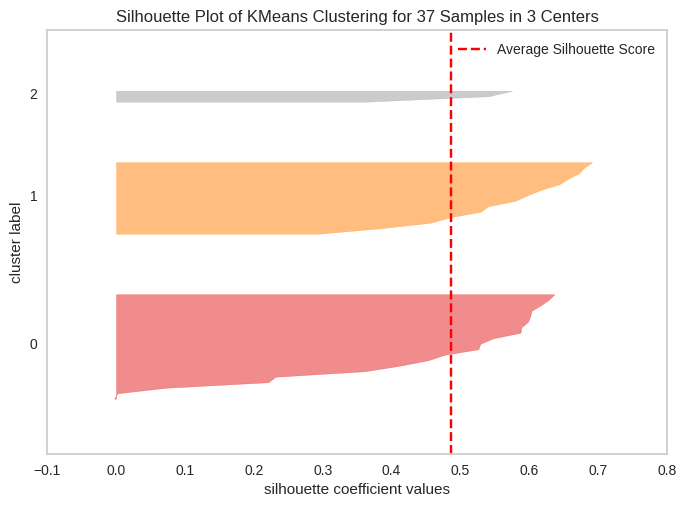

In [24]:
silhouette_viz = SilhouetteVisualizer(model)
silhouette_viz.fit(x)
plt.grid(False)
silhouette_viz.show()
plt.show()